In [636]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric, type_metric


import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from functions import *
import random

from sklearn.metrics import pairwise_distances
from pyclustering.cluster import kmedoids, silhouette


Reference: https://medium.com/@blazetamareborn/practicing-clustering-techniques-on-survey-dataset-f7d7a322e6ff

In [637]:
X = pd.read_csv("indep_x.csv", index_col = 0)
y = pd.read_csv("dep_y.csv", index_col = 0)

In [638]:
df = pd.concat([X,y], axis = 1)

In [639]:
# Here we assume that if someone has no gpa it's because they didn't pass any exam, 
# so we use 17 as placeholder

X.loc[X["gpa"] == 31, "gpa"] = 17
df.loc[df["gpa"] == 31, "gpa"] = 17

#X = X[X["gpa"]!=31]
# df = df[df["gpa"]!=31]

In [640]:
scaler = StandardScaler()
s_data_df = scaler.fit_transform(df)
s_data_X = scaler.fit_transform(X)

### Removal of Outliers using DBSCAN

In [641]:
dbscan = DBSCAN(eps=3.5, min_samples=20)

labels = dbscan.fit_predict(s_data_X)
outlier_mask = labels == -1

In [377]:
x_data_nout = s_data_X[~outlier_mask]
all_data_nout = s_data_df[~outlier_mask]

In [378]:
x_nout = X[~outlier_mask]
df_nout = df[~outlier_mask]

In [379]:
df_nout.shape[0]/df.shape[0]

0.8431372549019608

In [381]:
df_nout.shape

(129, 16)

In [380]:
df_nout.to_csv("data_nout.csv")

### PCA Processing

In [642]:
# data_nout = pd.read_csv("data_nout.csv", index_col = 0)

In [643]:
# x_nout = data_nout[['age', 'gender', 'scholarship', '1st_year', 'gpa', '1st_time', 'taste',
#                       'importance', 'expected_grade', 'knowledge']].copy()
# y_nout = data_nout[['grade_goal','confidence', 'anxiety', 'time', 'exam_date']].copy()

# treatment = data_nout["treated"].copy()

allX_notreatment = X.drop(["treated"], axis = 1)

In [644]:
s_x_nout = scaler.fit_transform(allX_notreatment)

In [645]:
pca = PCA(n_components = 2, random_state=1)
x_pca = pca.fit_transform(s_x_nout)

In [646]:
pca.explained_variance_ratio_.sum()

0.3283050247711032

In [647]:
x_pca.shape

(153, 2)

In [648]:
# Manhattan distance matrix
distance_matrix = pairwise_distances(x_pca, metric="euclidean")

# K-Medoids clustering
k = 3 # example number of clusters
num_data_points = len(x_pca)

initial_medoids = random.sample(range(num_data_points), k)

kmedoids_instance = kmedoids.kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()

silhouette_instance = silhouette.silhouette(x_pca, clusters)
silhouette_score = silhouette_instance.process().get_score()

print("Silhouette Score:", np.mean(silhouette_score))

Silhouette Score: 0.555353457470413


In [649]:
labels = np.zeros(len(x_pca), dtype=int)
for i, cluster in enumerate(clusters):
    labels[cluster] = i

In [650]:
x_pca_df = pd.DataFrame(x_pca)

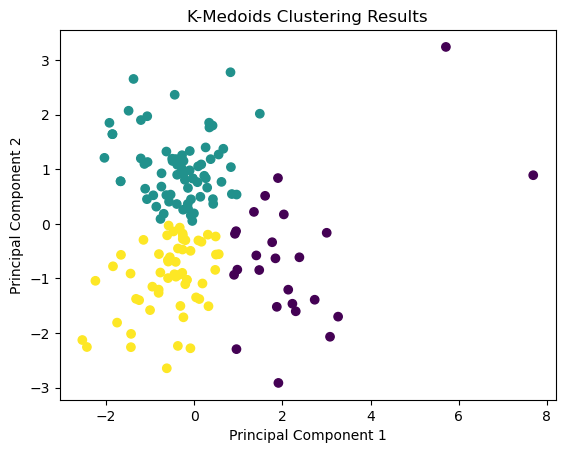

In [651]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=labels)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Medoids Clustering Results")
plt.show()

In [652]:
labels = pd.DataFrame(labels)

In [653]:
x_nout_updated = allX_notreatment.copy()

In [654]:
labels.index = allX_notreatment.index
labels.columns = ["cluster"]

In [655]:
x_nout_updated = pd.concat([x_nout_updated, labels], axis = 1)

In [656]:
x_nout_updated.to_csv("x_nout_cluster.csv")

In [657]:
print(x_nout_updated.groupby("cluster")[x_nout_updated.columns].mean())

            age  gender  scholarship  1st_year     gpa  1st_time  taste  \
cluster                                                                   
0       21.4400  0.2400       0.0000    0.6000 21.7200    0.9200 2.9600   
1       19.2958  0.7746       0.1549    1.0000 25.4366    1.0000 3.1127   
2       19.7544  0.1930       0.0000    1.0000 24.1930    0.9825 3.7895   

         importance  expected_grade  knowledge  cluster  
cluster                                                  
0            3.5200         21.0400     0.1600   0.0000  
1            3.7746         22.5634     0.2535   1.0000  
2            4.3158         21.4561     0.4211   2.0000  


In [658]:
x_nout_updated.shape

(153, 11)

In [659]:
y_vars = pd.concat([y, x_nout_updated["cluster"]], axis = 1)

In [661]:
x_nout_updated = pd.concat([x_nout_updated, X["treated"]], axis = 1)

In [662]:
ate_results = {}
p_values = {}

for cluster_id in x_nout_updated['cluster'].unique():
    ate_results[cluster_id] = {}
    p_values[cluster_id] = {}
    for var in y_vars.columns[:-1]:
        cluster_data = x_nout_updated[x_nout_updated['cluster'] == cluster_id].drop(["cluster"], axis = 1)
        X = sm.add_constant(cluster_data) 
        y_reg = y_vars[y_vars['cluster'] == cluster_id].copy()
        y_reg = y_reg[var] 
        model = sm.RLM(y_reg, X, M = sm.robust.norms.HuberT()).fit()
        ate_results[cluster_id][var] = model.params['treated']
        p_values[cluster_id][var] = model.pvalues['treated']

In [663]:
pd.options.display.float_format = '{:.4f}'.format

(pd.DataFrame(ate_results),pd.DataFrame(p_values))

(                 1       0       2
 grade_goal -2.2022 -2.6007 -0.2039
 confidence -0.1301 -0.2705  0.1103
 anxiety     0.2115 -0.1827  0.0304
 time        0.3166  0.8310  0.2983
 exam_date  -0.0000 -0.3116  0.0000,
                 1      0      2
 grade_goal 0.0000 0.0306 0.8396
 confidence 0.4763 0.4253 0.6383
 anxiety    0.4706 0.5291 0.8972
 time       0.2614 0.2303 0.3094
 exam_date  0.7386 0.2886 0.9087)

In [664]:
x_nout_updated["cluster"].value_counts()

1    71
2    57
0    25
Name: cluster, dtype: int64